In [1]:
import pyreadstat
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Оптимизатор

In [2]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_w, self.v_w = 0, 0  # Moments for weights
        self.m_b, self.v_b = 0, 0  # Moments for biases
        self.t = 0  # Time step
    
    def update(self, weights, biases, dW, db):
        # Increment time step
        self.t += 1
        
        # Update biased first moment estimate
        self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * dW
        self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * db
        
        # Update biased second moment estimate
        self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (dW**2)
        self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (db**2)
        
        # Compute bias-corrected first moment estimate
        m_w_hat = self.m_w / (1 - self.beta1**self.t)
        m_b_hat = self.m_b / (1 - self.beta1**self.t)
        
        # Compute bias-corrected second moment estimate
        v_w_hat = self.v_w / (1 - self.beta2**self.t)
        v_b_hat = self.v_b / (1 - self.beta2**self.t)
        
        # Compute the updates
        weight_update = self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
        bias_update = self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
        
        # Update parameters
        weights -= weight_update
        biases -= bias_update
        
        return weights, biases

# Multi Class Logistic Regression

In [3]:
class MulticlassLogisticRegression:
    def __init__(self, num_features, num_classes, learning_rate=0.01, batch_size=32, epochs=1000, log_freq=100, log=False):
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        
        self.weights = np.random.randn(num_features, num_classes) * 0.1
        self.biases = np.random.randn(num_classes) * 0.1

        self.optimizer = AdamOptimizer(learning_rate=learning_rate)
        self.log_freq = log_freq
        self.log = log

        # RMSProp параметры
        self.beta = 0.9  # коэффициент сглаживания
        self.epsilon = 1e-8  # чтобы избежать деления на 0
        self.weight_cache = np.zeros_like(self.weights)  # скользящее среднее для весов
        self.bias_cache = np.zeros_like(self.biases)  # скользящее среднее для смещений
    
    def fit(self, X, y, optimizer = 'Naive'):
        n_samples, n_features = X.shape

        self.losses = []
        self.accuracy_arr = []
        self.f1_arr = []
        self.roc_arr = []
        for epoch in range(self.epochs):
            # Берём рандомный батч из входных данных
            indices = np.random.choice(n_samples, self.batch_size, replace=False)
            X_batch = X.iloc[indices]
            y_batch = y.iloc[indices]
            y_batch_one_hot = self.one_hot(y_batch)

            # Считаем логиты(-inf inf) и softmax (0 1)
            y_pred = self.predict_(X_batch)
            
            # Считаем cross_entropy чем ближе y_pred к y_batch_one_hot, тем меньше loss
            loss = self.cross_entropy(y_batch_one_hot, y_pred)

            # Считаем градиенты
            error = y_batch_one_hot - y_pred
            dW = np.dot(X_batch.T, (error)) / len(y_batch_one_hot)
            db = np.sum(error) / len(y_batch_one_hot)


            if optimizer == 'RMSProp':
                self.weight_cache = self.beta * self.weight_cache + (1 - self.beta) * dW**2
                self.bias_cache = self.beta * self.bias_cache + (1 - self.beta) * db**2

                shiftW = self.learning_rate * dW / (np.sqrt(self.weight_cache) + self.epsilon)
                self.weights -= shiftW
                self.biases -= self.learning_rate * db / (np.sqrt(self.bias_cache) + self.epsilon)
            if optimizer == 'Adam':
                self.weights, self.biases = self.optimizer.update(self.weights, self.biases, dW, db)
            else:
                w = self.weights
                self.weights -= self.learning_rate * dW
                self.biases -= self.learning_rate * db

            if epoch % self.log_freq == 0:
                y_pred, accuracy, f1, roc = self.predict(X_batch, y_batch)
                self.losses.append(loss)
                self.accuracy_arr.append(accuracy)
                self.f1_arr.append(f1)
                self.roc_arr.append(roc)
                if self.log:
                    print(f"Epoch {epoch}, Loss: {loss:.4f}, accuracy: {accuracy}, f1: {f1}, ROC: {roc}")

        
    def one_hot(self, y):
        one_hot = np.zeros((y.size, self.num_classes))
        for i in range(len(one_hot)):
            one_hot[i][y.iloc[i]] = 1
        return one_hot
    
    def predict_(self, X):
        logits = np.dot(X, self.weights) + self.biases
        y_pred = self.softmax(logits)
        return y_pred

    def softmax(self, z):
        z = np.clip(z, -200, 200)
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)

    def cross_entropy(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -1 * np.mean(y_true * np.log(y_pred))

    def predict(self, X, y_true):
        y_pred = self.predict_(X)
        y_pred = np.argmax(y_pred, axis=1)

        accuracy = self.accuracy(y_true, y_pred)
        f1 = self.f1_score(y_true, y_pred)
        roc = self.roc_auc(y_true, y_pred)
        return y_pred, accuracy, f1, roc

    def accuracy(self, y_true, y_pred):
        correct_predictions = np.sum(y_true == y_pred)
        return correct_predictions / len(y_true)

    def f1_score(self, y_true, y_pred):
        unique_classes = np.unique(np.concatenate([y_true, y_pred]))

        f1_scores = []
        weights = []
        
        for cls in unique_classes:
            tp = np.sum((y_true == cls) & (y_pred == cls))
            fp = np.sum((y_true != cls) & (y_pred == cls))
            fn = np.sum((y_true == cls) & (y_pred != cls))
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            if precision + recall > 0:
                f1 = 2 * (precision * recall) / (precision + recall)
            else:
                f1 = 0
            
            support = np.sum(y_true == cls)
            f1_scores.append(f1)
            weights.append(support)
        
        weighted_f1 = np.average(f1_scores, weights=weights)
        return weighted_f1

    def roc_auc(self, y_true: np.array, y_pred: np.array, n_classes = 5) -> float:
        # Преобразование в one-hot encoding
        y_true_one_hot = np.eye(n_classes)[y_true]
        y_pred_one_hot = np.eye(n_classes)[y_pred]

        # Вычисление AUC для каждого класса
        auc_per_class = {}
        for class_idx in range(n_classes):
            y_true_class = y_true_one_hot[:, class_idx]
            y_pred_class = y_pred_one_hot[:, class_idx]

            # Проверяем, есть ли положительные примеры
            if len(np.unique(y_true_class)) < 2:
                auc_per_class[class_idx] = None  # AUC не определен
                continue

            auc_per_class[class_idx] = roc_auc_score(y_true_class, y_pred_class)

        # Среднее значение по классам, исключая None
        valid_aucs = [auc for auc in auc_per_class.values() if auc is not None]
        average_auc = np.mean(valid_aucs) if valid_aucs else 0.5

        return average_auc

    def visualize_metrics(self, dataName, y_train, y_test, predictions, accuracy, f1, roc_auc):
        epochs = range(1, len(self.accuracy_arr) + 1)
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))

        classes = np.arange(0,5,1)
        num_classes = len(classes) 
        bins = np.arange(num_classes + 1) - 0.5

        axes[0, 0].hist(y_train, bins=bins, color='blue', alpha=0.7, edgecolor='black', label='Распределение классов')
        axes[0, 0].set_title('Распределение данных')
        axes[0, 0].set_xlabel('Класс')
        axes[0, 0].set_ylabel('Количество')
        axes[0, 0].set_xticks(classes)

        axes[0, 1].hist(y_test, bins=bins, color='orange', alpha=0.7, edgecolor='black', label='Распределение классов')
        axes[0, 1].set_title('Распределение тестовых данных')
        axes[0, 1].set_xlabel('Класс')
        axes[0, 1].set_ylabel('Количество')
        axes[0, 1].set_xticks(classes)

        axes[0, 2].hist(predictions, bins=bins, color='green', alpha=0.7, edgecolor='black', label='Распределение ответов')
        axes[0, 2].set_title('Распределение ответов')
        axes[0, 2].set_xlabel('Класс')
        axes[0, 2].set_ylabel('Количество')
        axes[0, 2].set_xticks(classes)

        metrics = ['ROC AUC', 'F1 Score', 'Accuracy']
        values = [roc_auc, f1, accuracy]
        bars = axes[0, 3].barh(metrics, values, color=['brown', 'green', 'orange'], edgecolor='black', height=0.6)
        for bar in bars:
            axes[0, 3].text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, f"{bar.get_width():.2f}", ha='left', va='center', fontsize=12, color='black')
        axes[0, 3].set_xlim(0, 1)
        axes[0, 3].set_title('Тестовые метрики')
        axes[0, 3].grid(axis='x', linestyle='--', alpha=0.7)

        trend_line = np.polyval(np.polyfit(epochs, self.losses, deg=1), epochs)
        axes[1, 0].plot(epochs, self.losses, label="Loss", color='blue', marker='^')
        axes[1, 0].plot(epochs, trend_line, label='Линия тренда', color='red', linestyle='--')
        axes[1, 0].set_title(f"Loss {dataName}")
        axes[1, 0].set_xlabel("Эпохи")
        axes[1, 0].set_ylabel("Loss")
        axes[1, 0].grid(True)

        trend_line = np.polyval(np.polyfit(epochs, self.accuracy_arr, deg=1), epochs)
        axes[1, 1].plot(epochs, self.accuracy_arr, label="Accuracy", color='orange', marker='^')
        axes[1, 1].plot(epochs, trend_line, label='Линия тренда', color='red', linestyle='--')
        axes[1, 1].set_title(f"Accuracy {dataName}")
        axes[1, 1].set_xlabel("Эпохи")
        axes[1, 1].set_ylabel("Accuracy")
        axes[1, 1].grid(True)

        trend_line = np.polyval(np.polyfit(epochs, self.f1_arr, deg=1), epochs)
        axes[1, 2].plot(epochs, self.f1_arr, label="F1 Score", color='green', marker='^')
        axes[1, 2].plot(epochs, trend_line, label='Линия тренда', color='red', linestyle='--')
        axes[1, 2].set_title(f"F1 Score {dataName}")
        axes[1, 2].set_xlabel("Эпохи")
        axes[1, 2].set_ylabel("F1 Score")
        axes[1, 2].grid(True)

        trend_line = np.polyval(np.polyfit(epochs, self.roc_arr, deg=1), epochs)
        axes[1, 3].plot(epochs, self.roc_arr, label="ROC AUC", color='brown', marker='^')
        axes[1, 3].plot(epochs, trend_line, label='Линия тренда', color='red', linestyle='--')
        axes[1, 3].set_title(f"ROC AUC {dataName}")
        axes[1, 3].set_xlabel("Эпохи")
        axes[1, 3].set_ylabel("ROC AUC")
        axes[1, 3].grid(True)

        plt.tight_layout()
        plt.show()

        

Загрузка датасета

In [4]:
def readMult(path = 'data/r29i_os_73.sav', labell='label', filter=True, type='sav'):
    dataset, meta = pyreadstat.read_sav('data/r29i_os_73.sav')
    required_columns = ['yj1.1.1', 'yj13.2', 'yj72.18a', 'yj6.2', 'yj10.2', 'yj21b']
    dataset = dataset[required_columns]
    dataset = dataset.rename(columns={
        'yj1.1.1': 'label',
        'yj13.2': 'salary',
        'yj72.18a': 'education',
        'yj6.2': 'working_hours',
        'yj10.2': 'bonus',
        'yj21b': 'vacation_days'
    })
    dataset = dataset.dropna()
    dataset = dataset[(dataset <= 1000000).all(axis=1)]
    dataset = dataset.astype(float)
    label = dataset['label'].astype(int)
    dataset = dataset.drop(columns=['label'])
    X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.3, shuffle=False)
    main_X_test = X_test
    main_y_test = y_test - 1

    if type == 'sav':
        dataset, meta = pyreadstat.read_sav(path)
    else:
        dataset = pd.read_csv(path)
    if filter:
        required_columns = ['yj1.1.1', 'yj13.2', 'yj72.18a', 'yj6.2', 'yj10.2', 'yj21b']
        dataset = dataset[required_columns]
        dataset = dataset.rename(columns={
            'yj1.1.1': 'label',
            'yj13.2': 'salary',
            'yj72.18a': 'education',
            'yj6.2': 'working_hours',
            'yj10.2': 'bonus',
            'yj21b': 'vacation_days'
        })
    dataset = dataset.dropna()
    dataset = dataset[(dataset <= 1000000).all(axis=1)]
    dataset = dataset.astype(float)
    label = dataset[labell].astype(int)
    dataset = dataset.drop(columns=[labell])

    X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.3, shuffle=False)
    
    main_X_train = X_train
    main_y_train = y_train - 1
    return main_X_train, main_X_test, main_y_train, main_y_test

In [5]:
num_features=5
num_classes=5
learning_rate=1e-10
batch_size=32
epochs=500
log_freq = 5
log=False
optimizer='Adam'
optimizer='Naive'
#optimizer='RMSProp'

# VISUALISATION

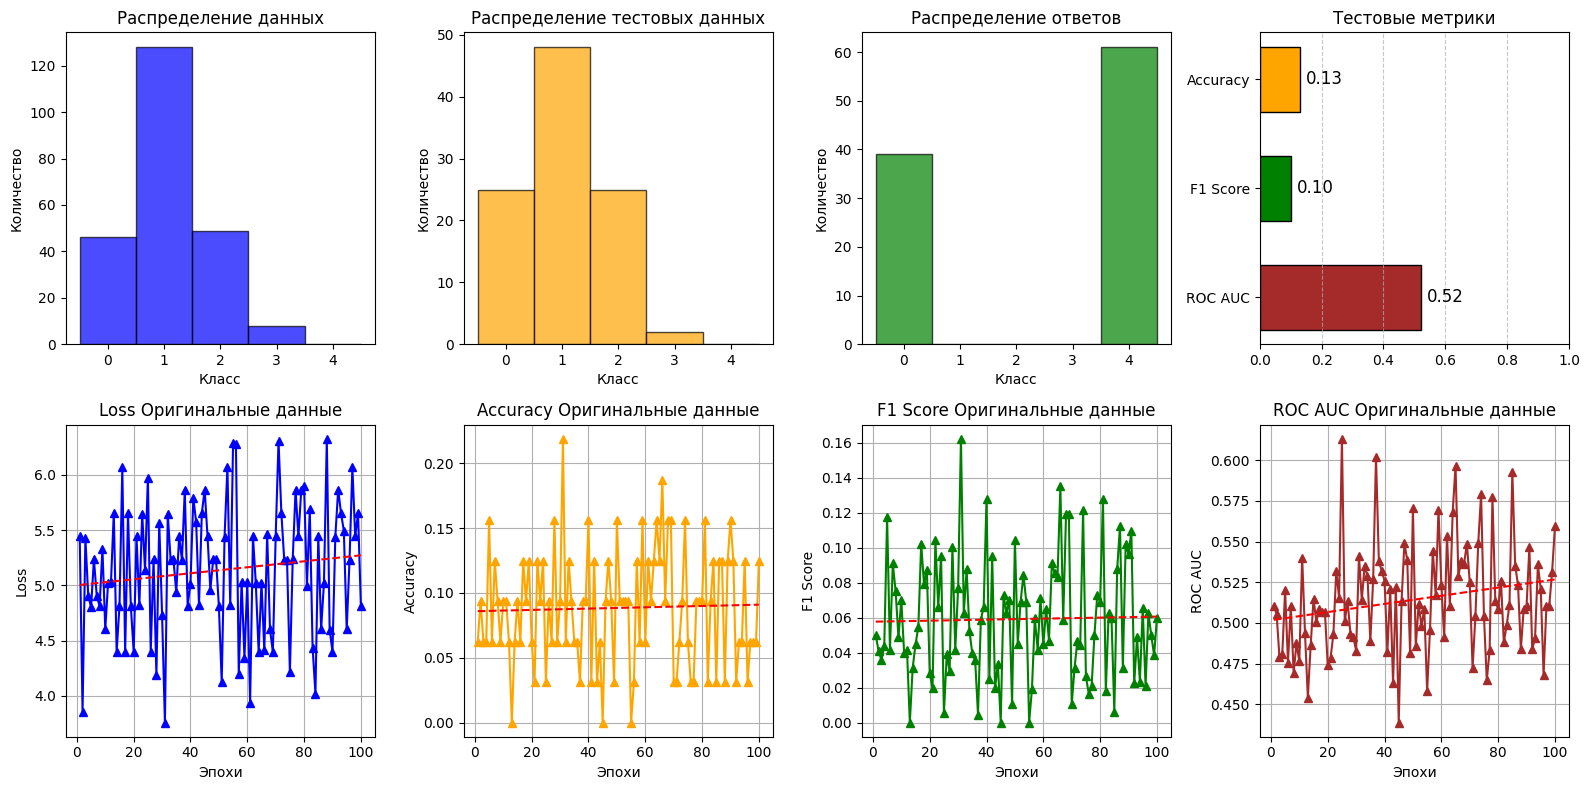

In [6]:
np.random.seed(90)
X_train, X_test, y_train, y_test = readMult(path = 'data/r29i_os_73.sav', labell='label', filter=True, type='sav')
model = MulticlassLogisticRegression(num_features=num_features, num_classes=num_classes, learning_rate=learning_rate, batch_size=32, epochs=epochs, log_freq=log_freq, log=log)
model.fit(X_train, y_train, optimizer=optimizer)
predictions, accuracy, f1, roc_auc= model.predict(X_test, y_test)
model.visualize_metrics("Оригинальные данные", y_train, y_test, predictions, accuracy, f1, roc_auc)

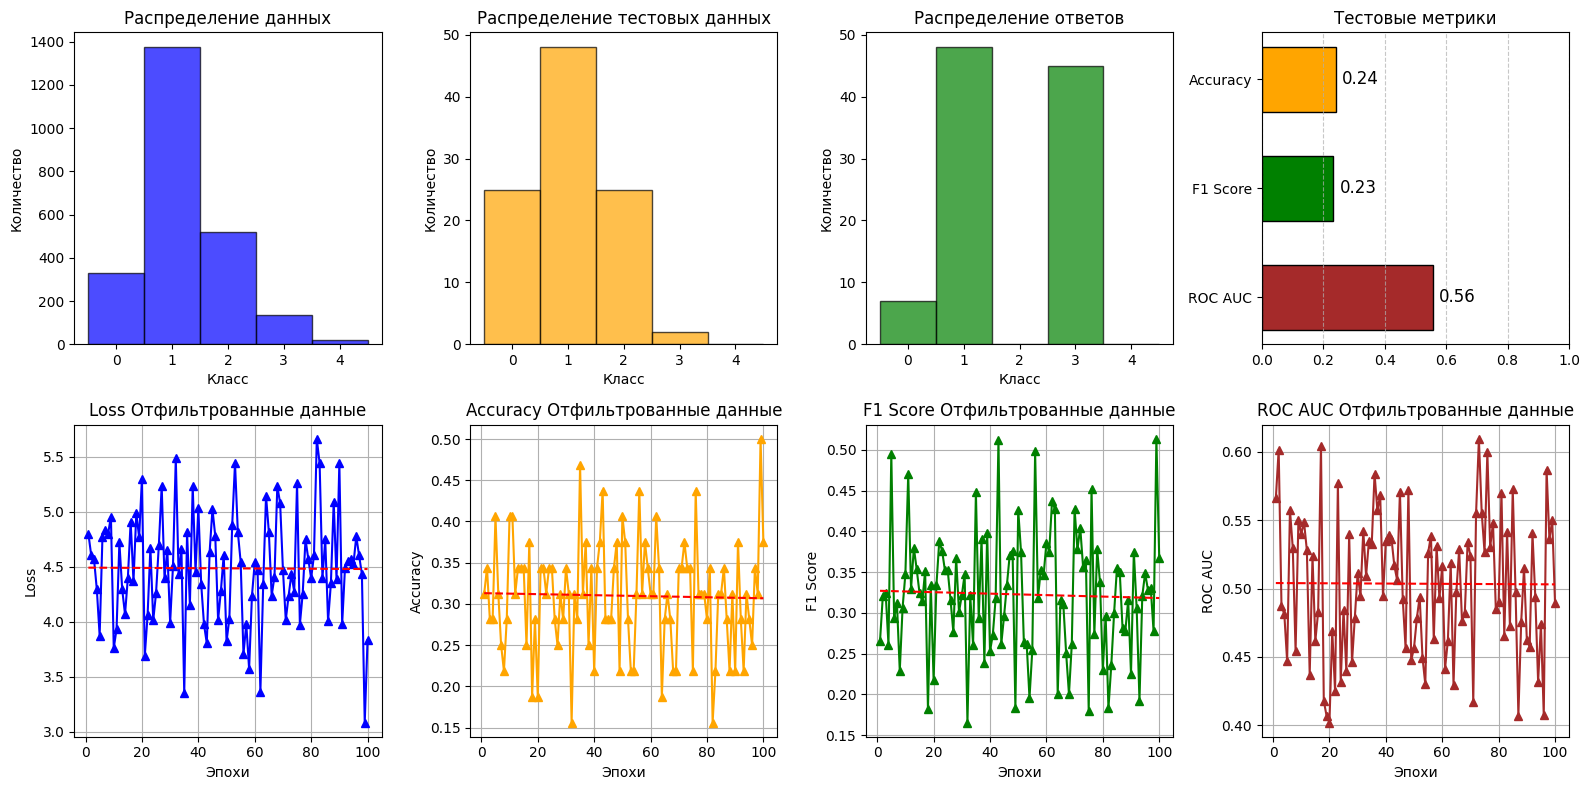

In [7]:
np.random.seed(96)
X_train, X_test, y_train, y_test = readMult(path = 'data/df2.csv', labell='label', filter=True, type='csv')
model = MulticlassLogisticRegression(num_features=num_features, num_classes=num_classes, learning_rate=learning_rate, batch_size=32, epochs=epochs, log_freq=log_freq, log=log)
model.fit(X_train, y_train, optimizer=optimizer)
predictions, accuracy, f1, roc_auc= model.predict(X_test, y_test)
model.visualize_metrics("Отфильтрованные данные", y_train, y_test, predictions, accuracy, f1, roc_auc)

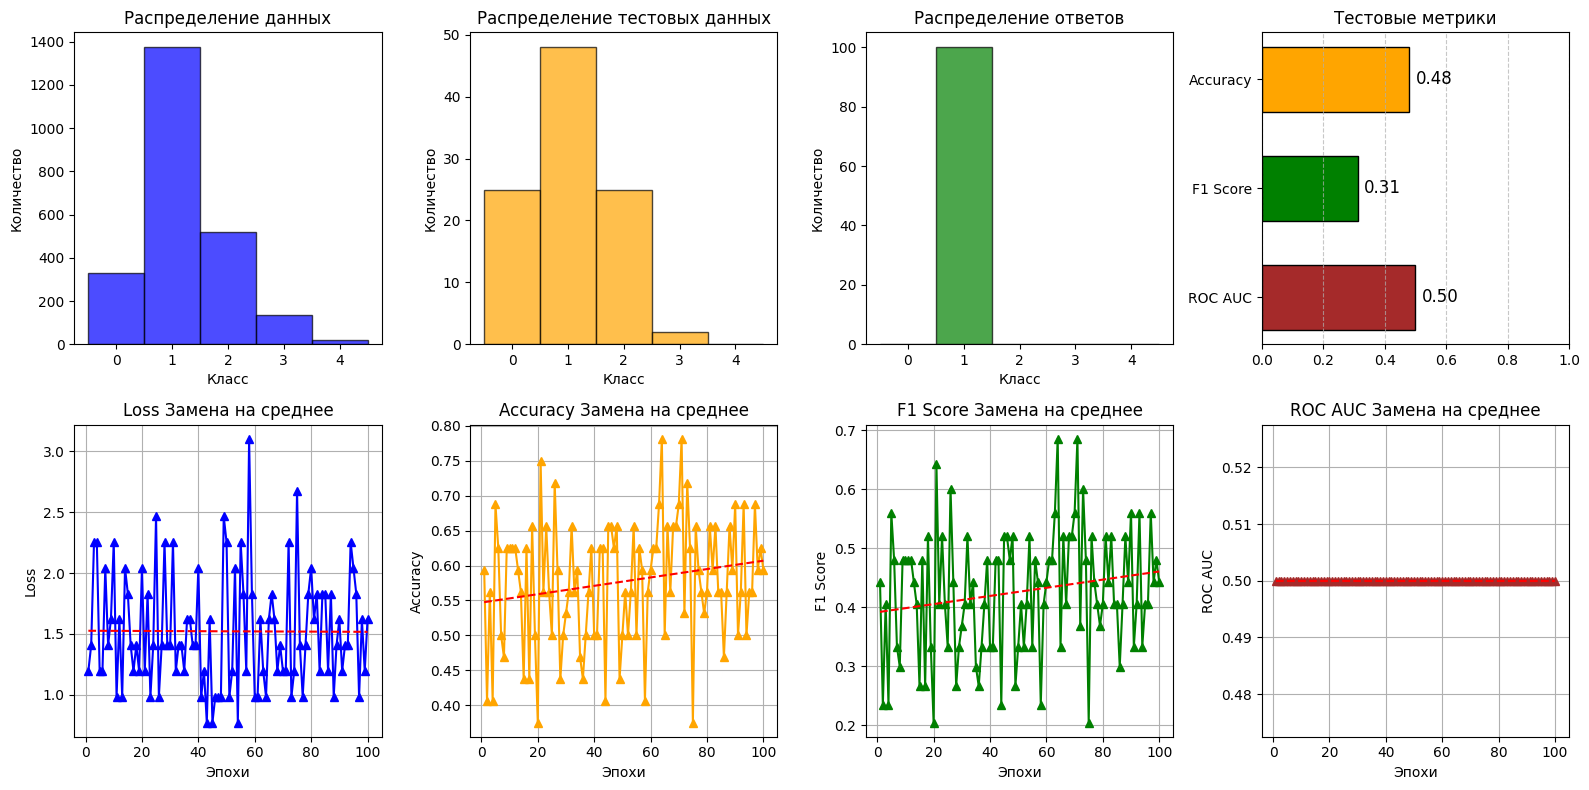

In [8]:
np.random.seed(44)
X_train, X_test, y_train, y_test = readMult(path = 'data/data_mean.sav', labell='Удовлетворенность', filter=False, type='sav')
model = MulticlassLogisticRegression(num_features=num_features, num_classes=num_classes, learning_rate=learning_rate, batch_size=32, epochs=epochs, log_freq=log_freq, log=log)
model.fit(X_train, y_train, optimizer=optimizer)
predictions, accuracy, f1, roc_auc= model.predict(X_test, y_test)
model.visualize_metrics("Замена на среднее", y_train, y_test, predictions, accuracy, f1, roc_auc)

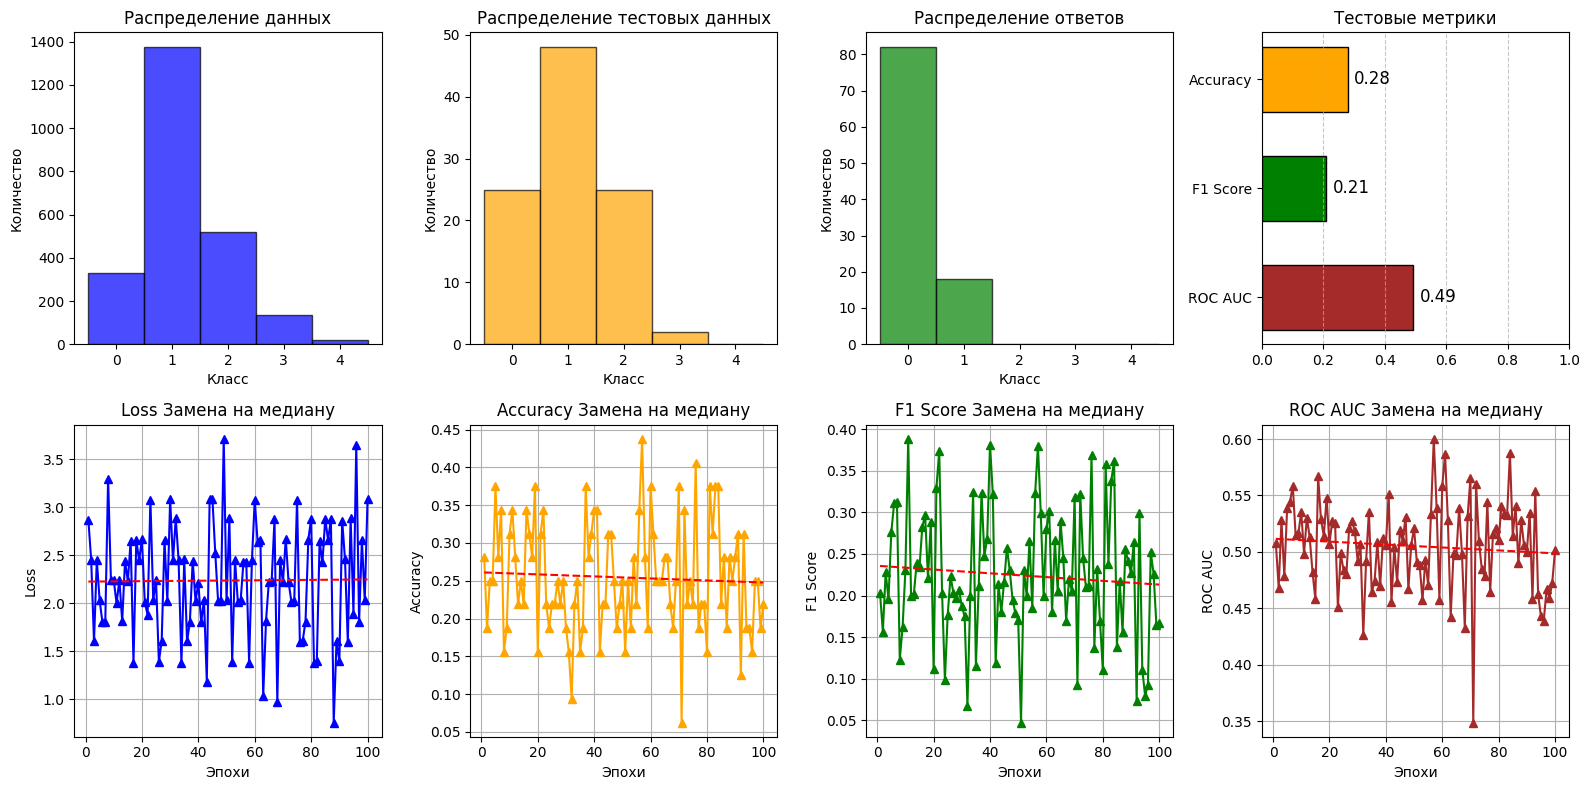

In [9]:
np.random.seed(92)
X_train, X_test, y_train, y_test = readMult(path = 'data/data_median.sav', labell='Удовлетворенность', filter=False, type='sav')
model = MulticlassLogisticRegression(num_features=num_features, num_classes=num_classes, learning_rate=learning_rate, batch_size=32, epochs=epochs, log_freq=log_freq, log=log)
model.fit(X_train, y_train, optimizer=optimizer)
predictions, accuracy, f1, roc_auc= model.predict(X_test, y_test)
model.visualize_metrics("Замена на медиану", y_train, y_test, predictions, accuracy, f1, roc_auc)